# PyTorch Bootcamp for CPSC 552

<div style="text-align:right">
Sumner Magruder & Mamie Wang
<br>
Janurary 20th 2023
</div>



<span style="font-size:8pt">
    <i>
        NOTE: the materials herein were adapted from PyTorch's official tutorial, which can be found 
        <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html">here</a>.
    </i> 
</span>


## Bookkeeping
- [Course Canvas](https://yale.instructure.com/courses/83743)
    - find announcements, files, homework assignments here.
- [Course GradeScope](https://www.gradescope.com/courses/486120)
    - submit your homework and review feedback here.
- Looking for last year's bootcamp? Follow this [link](https://yale.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=3bd5e0d8-6de4-4df1-b3ff-ae2d0145a4c8)
- Looking to book a room? Use [25live](https://25live.collegenet.com/pro/yale)

# Installation and Set up
If you haven't set up PyTorch locally, you can do so following this [local installation guide](https://pytorch.org/get-started/locally/).


Installing PyTorch locally is **not** necessary for the course. You can access PyTorch either through:

- the class partition `cpsc452` on [Farnam](https://docs.ycrc.yale.edu/clusters/farnam/)

- use of [Google Colab](https://colab.research.google.com)

If you are new to the Yale High Performance Clusters (HPC) please consulte this [guide](https://docs.ycrc.yale.edu/clusters-at-yale/) 
<div style="display:none">
```bash
[farnam ~]$ salloc ---reservation=cpsc452
[cpsc452_netID@gpu ~]$  bash
```
```bash
# sbatch.script
@SBATCH -p cpsc452
```
</div>


## Above and beyond (not required)

### PyTorch extensions
[PyLightning](https://www.pytorchlightning.ai) makes experiment tracking easier (metrics, visualzation, etc). 
Those who are interested in continuing in with PyTorch may find PyLighting a great tool in powering up their research.

### MLOps (Machine Learning development OPS)
These tools are useful for managing your ML experiements (think hyperparameter experiments, visualizations, saving key results, etc).
They are **NOT** needed for the course. They are however of interest for students who may like to invest some time upfront for future projects 
(possibly even the course project).
- [TensorBoard](https://www.tensorflow.org/tensorboard) ([pytorch tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html))
- [Comet](https://www.comet.com/site/)
- [Weights & Biases](https://wandb.ai/)
- [Neptune](https://neptune.ai)
- [MLFlow](https://mlflow.org)

If this is too much choice, here is a [short guide](https://neptune.ai/blog/weights-and-biases-alternatives) comparing some of these (Neptune's site, so take it with a grian of salt).

In [1]:
%matplotlib inline

# Training a Classifier

## What about data?

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_images/cifar10.png)


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [2]:
num_workers = 2
batch_size = 4

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



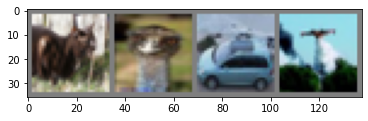

cat   bird  car   plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, use_convolutions:bool=False):
        super().__init__()
        self.use_convolutions = use_convolutions

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.flat = nn.Flatten() 
        self.conv_matcher = nn.Linear(3 * 32 * 32, 16 * 5 * 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        if self.use_convolutions:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        else:
            x = self.flat(x)
            x = self.conv_matcher(x)
            x = F.relu(x)            
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net(use_convolutions=False)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
def train_step(model, data, optimizer=optimizer, criterion=criterion, scheduler=None, data_idx=None):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize + scheduler
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() 
        
    return loss
    
def train_loop(
    model, dataloader, epochs=2,  optimizer=optimizer, 
    criterion=criterion, scheduler=None, basename = './model'
):
    model.train() # set net to training mode
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            loss = train_step(model, data, optimizer, criterion, scheduler, data_idx=i)

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                
        
                
        if scheduler is not None:
            scheduler.step()
        
        model.eval()
        # calc test set acc
        
        if test_acc improves, epoch % 2 == 0:
            torch.save(net.state_dict(), f'./{basename}_{epoch}.model')
            
    print('Finished Training')

train_loop(net, trainloader, epochs=2, scheduler=scheduler)

[1,  2000] loss: 2.056
[1,  4000] loss: 2.051
[1,  6000] loss: 2.082
[1,  8000] loss: 2.109
[1, 10000] loss: 2.129
[1, 12000] loss: 2.132
[2,  2000] loss: 2.158
[2,  4000] loss: 2.169
[2,  6000] loss: 2.230
[2,  8000] loss: 2.234
[2, 10000] loss: 2.176
[2, 12000] loss: 2.188
Finished Training


Let's quickly save our trained model:



In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**NOTE:** it may be tempting to just use `torch.save(net, PATH)` but this has a serious drawback!
> The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved.
For more please consult the [saving model guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch objects (tensors, modules, models).



### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



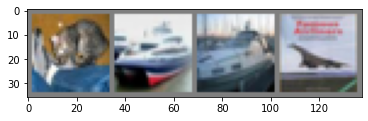

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net = Net(use_convolutions=False) # NOTE: make sure you have use_convolutions the same when you trained it!
net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
net.eval()
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  ship  ship 


The results seem pretty bad! It just predicts a single class for every image. 
This kind of behavior is called mode collapse. Let's see if we can improve our results by switching now to a convolutional neural network.
If you don't know what a convolutional neural network is, **don't panic**. That is why you are taking the class! However, we can
still use them to see why we might be interested in learning about them.

In [13]:
c_net = Net(use_convolutions=True)
c_criterion = nn.CrossEntropyLoss()
c_optimizer = optim.SGD(c_net.parameters(), lr=0.01, momentum=0.9)
c_scheduler = StepLR(c_optimizer, step_size=10, gamma=0.1)

In [14]:
train_loop(c_net, trainloader, 2, c_optimizer, c_criterion, c_scheduler)

/Users/sumner/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.094
[1,  4000] loss: 1.996
[1,  6000] loss: 1.924
[1,  8000] loss: 1.942
[1, 10000] loss: 1.927
[1, 12000] loss: 1.980
[2,  2000] loss: 1.963
[2,  4000] loss: 1.957
[2,  6000] loss: 1.949
[2,  8000] loss: 1.960
[2, 10000] loss: 1.946
[2, 12000] loss: 1.981
Finished Training


In [ ]:
PATH = './cifar_cnet.pth'
torch.save(c_net.state_dict(), PATH)

# Evaluation

In [15]:
c_net.eval()
outputs = c_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = c_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 27 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [17]:
def eval_classes(model, dataloader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    return correct_pred, total_pred

print('Class eval for net:\n___________________')
cp, tp = eval_classes(net, testloader)
# for classname, correct_count in cp.items():
#         accuracy = 100 * float(correct_count) / tp[classname]
#         print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print('Class eval for c_net:\n___________________')
cp, tp = eval_classes(c_net, testloader)
# for classname, correct_count in cp.items():
#         accuracy = 100 * float(correct_count) / tp[classname]
#         print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Class eval for net:
___________________
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.2 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 1.6 %
Accuracy for class: ship  is 85.5 %
Accuracy for class: truck is 0.3 %
Class eval for c_net:
___________________
Accuracy for class: plane is 0.6 %
Accuracy for class: car   is 36.5 %
Accuracy for class: bird  is 2.8 %
Accuracy for class: cat   is 10.0 %
Accuracy for class: deer  is 9.7 %
Accuracy for class: dog   is 11.2 %
Accuracy for class: frog  is 66.5 %
Accuracy for class: horse is 52.2 %
Accuracy for class: ship  is 59.0 %
Accuracy for class: truck is 23.2 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images


In [ ]:
del dataiter